In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import antropy as ant
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks, correlate
from scipy.signal import butter, filtfilt

In [34]:
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def compute_features_respiration(epoch):
    var = np.var(epoch)
    zcr = ((epoch[:-1] * epoch[1:]) < 0).sum()
    mmd = compute_mmd(epoch)
    esis = compute_esis(epoch, 100)
    return [
        var,
        zcr,
        mmd,
        esis
    ]

def compute_mmd(epoch, window_size = 50, step_size = 25):
    mmd = 0
    for start in range(0, len(epoch) - window_size, step_size):
        window = epoch[start:start + window_size]

        max_idx = np.argmax(window)
        min_idx = np.argmin(window)

        delta_x = max_idx - min_idx
        delta_y = window[max_idx] - window[min_idx]

        distance = np.sqrt(delta_x ** 2 + delta_y ** 2)
        mmd += distance
    return mmd

def compute_esis(epoch, fs):
    
    energy = np.square(epoch)
    slope = np.abs(np.diff(epoch, prepend=epoch[0]))
    v = fs * slope
    esis = np.sum(energy * v)
    return esis

def hjorth_parameters(epoch):
    first_deriv = np.diff(epoch)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(epoch)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return complexity


def bandpower(sig, fs, band):  #filtrira signale po frekvencijama
    low, high = band
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    filtered = filtfilt(b, a, sig)
    power = np.sum(filtered ** 2) / len(filtered)
    return power 

def compute_features(epoch):
    mmd = compute_mmd(epoch)
    zcr = ((epoch[:-1] * epoch[1:]) < 0).sum()
    esis = compute_esis(epoch, 100)
    ptp = np.mean(np.ptp(epoch))
    hj_complexity = hjorth_parameters(epoch)
    waves = {name: bandpower(epoch, 100, band) for name, band in bands.items()}
    return [mmd, zcr, esis, ptp, hj_complexity, waves['alpha'], waves['gamma'], waves['theta']]

def compute_features_shortened(epoch):
    mmd = compute_mmd(epoch)
    zcr = ((epoch[:-1] * epoch[1:]) < 0).sum()
    esis = compute_esis(epoch, 100)
    ptp = np.mean(np.ptp(epoch))
    hj_complexity = hjorth_parameters(epoch)
    waves = {name: bandpower(epoch, 100, band) for name, band in bands.items()}
    return [mmd, zcr, esis, ptp, hj_complexity, waves['alpha']]

def compute_eog_features(e1_epoch, e2_epoch):
    # 1. EOG Differential Signal (E1 - E2)
    eog_diff = e1_epoch - e2_epoch
    diff_var = np.var(eog_diff)

    # 2. Zero Crossing Rate (ZCR) - individual channels
    zcr_e1 = ((e1_epoch[:-1] * e1_epoch[1:]) < 0).sum()

    # 3. Blink / Peak Count - individual channels
    peaks_e1, _ = find_peaks(np.abs(e1_epoch), height=np.std(e1_epoch))
    peaks_e2, _ = find_peaks(np.abs(e2_epoch), height=np.std(e2_epoch))
    peak_count_e1 = len(peaks_e1)

    # 4. Cross-Correlation between E1 and E2
    corr = correlate(e1_epoch, e2_epoch, mode='full')
    lags = np.arange(-len(e1_epoch)+1, len(e1_epoch))
    lag_at_max = lags[np.argmax(np.abs(corr))]

    return [
        diff_var,       # EOG Variance
        zcr_e1,         # ZCR E1
        peak_count_e1,  # Peaks E1
        lag_at_max      # Lag at max corr
    ]

In [35]:
folder = "C:/Analiza Faza Sna/Dataset"
files = [f for f in os.listdir(folder) if f.endswith(".csv")]


fs = 100
samples_per_epoch = fs * 30

all_subjects = []

for file in files[:1]:
    df = pd.read_csv(os.path.join(folder, file))
    df = df[(df["Sleep_Stage"] != 'P') & (df["Sleep_Stage"] != 'Missing')]

    F4 = df["F4-M1"].values
    C4 = df["C4-M1"].values
    O2 = df["O2-M1"].values
    Fp1 = df["Fp1-O2"].values
    E1 = df["E1"].values
    E2 = df["E2"].values
    ECG = df["ECG"].values
    T3 = df["T3 - CZ"].values
    Cz= df["CZ - T4"].values
    CHIN = df["CHIN"].values
    LAT = df["LAT"].values
    RAT = df["RAT"].values
    FLOW = df["FLOW"].values
    PTAF = df["PTAF"].values
    THORAX = df["THORAX"].values
    ABDOMEN = df["ABDOMEN"].values
    labels = df["Sleep_Stage"].values
    num_epochs = len(E1) // samples_per_epoch
    F4_epochs = np.array_split(F4[:num_epochs * samples_per_epoch], num_epochs)
    O2_epochs = np.array_split(O2[:num_epochs * samples_per_epoch], num_epochs)
    C4_epochs = np.array_split(C4[:num_epochs * samples_per_epoch], num_epochs)
    Fp1_epochs = np.array_split(Fp1[:num_epochs * samples_per_epoch], num_epochs)
    E1_epochs = np.array_split(E1[:num_epochs * samples_per_epoch], num_epochs)
    E2_epochs = np.array_split(E2[:num_epochs * samples_per_epoch], num_epochs)
    ECG_epochs = np.array_split(ECG[:num_epochs * samples_per_epoch], num_epochs)
    T3_epochs = np.array_split(T3[:num_epochs * samples_per_epoch], num_epochs)
    Cz_epochs = np.array_split(Cz[:num_epochs * samples_per_epoch], num_epochs)
    CHIN_epochs = np.array_split(CHIN[:num_epochs * samples_per_epoch], num_epochs)
    LAT_epochs = np.array_split(LAT[:num_epochs * samples_per_epoch], num_epochs)
    RAT_epochs = np.array_split(RAT[:num_epochs * samples_per_epoch], num_epochs)
    FLOW_epochs = np.array_split(FLOW[:num_epochs * samples_per_epoch], num_epochs)
    PTAF_epochs = np.array_split(PTAF[:num_epochs * samples_per_epoch], num_epochs)
    THORAX_epochs = np.array_split(THORAX[:num_epochs * samples_per_epoch], num_epochs)
    ABDOMEN_epochs = np.array_split(ABDOMEN[:num_epochs * samples_per_epoch], num_epochs)
    label_epochs = np.array_split(labels[:num_epochs * samples_per_epoch], num_epochs)

    features = []
    for (f4, c4, o2, fp1, e1, e2, ecg, t3, cz, chin, lat, rat, flow, ptaf, thorax, abdomen, label_epoch) in zip(
        F4_epochs, C4_epochs, O2_epochs, Fp1_epochs,
        E1_epochs, E2_epochs, ECG_epochs,
        T3_epochs, Cz_epochs, CHIN_epochs,
        LAT_epochs, RAT_epochs, FLOW_epochs,
        PTAF_epochs, THORAX_epochs, ABDOMEN_epochs, 
        label_epochs
    ):
        # EEG Features
        f4_features = compute_features(f4)
        c4_features = compute_features(c4)
        o2_features = compute_features(o2)
        fp1_features = compute_features(fp1)
        t3_features = compute_features(t3)
        cz_features = compute_features(cz)

        # EOG Features
        eog_features = compute_eog_features(e1, e2)

        # ECG Features
        ecg_features = compute_features_shortened(ecg)

        # EMG / Chin
        chin_features = compute_features_shortened(chin)

        # EOG Aux Channels
        lat_features = compute_features_shortened(lat)
        rat_features = compute_features_shortened(rat)

        # Respiration Features
        flow_features = compute_features_respiration(flow)
        ptaf_features = compute_features_respiration(ptaf)
        thorax_features = compute_features_respiration(thorax)
        abdomen_features = compute_features_respiration(abdomen)
        # Combine all features
        combined = np.concatenate([
            f4_features,
            c4_features,
            o2_features,
            fp1_features,
            t3_features,
            cz_features,
            eog_features,
            ecg_features,
            chin_features,
            lat_features,
            rat_features,
            flow_features,
            ptaf_features,
            thorax_features,
            abdomen_features
        ])

        features.append(combined)

    epoch_labels = [pd.Series(epoch).mode()[0] for epoch in label_epochs]
                        
    all_subjects.append((np.array(features), np.array(epoch_labels)))

In [36]:
X = np.vstack([subject[0] for subject in all_subjects])
y = np.hstack([subject[1] for subject in all_subjects])  

In [37]:
print("Example row types:")
for i, val in enumerate(X[0]):
    print(f"Feature {i}: {type(val)}")

Example row types:
Feature 0: <class 'numpy.float64'>
Feature 1: <class 'numpy.float64'>
Feature 2: <class 'numpy.float64'>
Feature 3: <class 'numpy.float64'>
Feature 4: <class 'numpy.float64'>
Feature 5: <class 'numpy.float64'>
Feature 6: <class 'numpy.float64'>
Feature 7: <class 'numpy.float64'>
Feature 8: <class 'numpy.float64'>
Feature 9: <class 'numpy.float64'>
Feature 10: <class 'numpy.float64'>
Feature 11: <class 'numpy.float64'>
Feature 12: <class 'numpy.float64'>
Feature 13: <class 'numpy.float64'>
Feature 14: <class 'numpy.float64'>
Feature 15: <class 'numpy.float64'>
Feature 16: <class 'numpy.float64'>
Feature 17: <class 'numpy.float64'>
Feature 18: <class 'numpy.float64'>
Feature 19: <class 'numpy.float64'>
Feature 20: <class 'numpy.float64'>
Feature 21: <class 'numpy.float64'>
Feature 22: <class 'numpy.float64'>
Feature 23: <class 'numpy.float64'>
Feature 24: <class 'numpy.float64'>
Feature 25: <class 'numpy.float64'>
Feature 26: <class 'numpy.float64'>
Feature 27: <class 

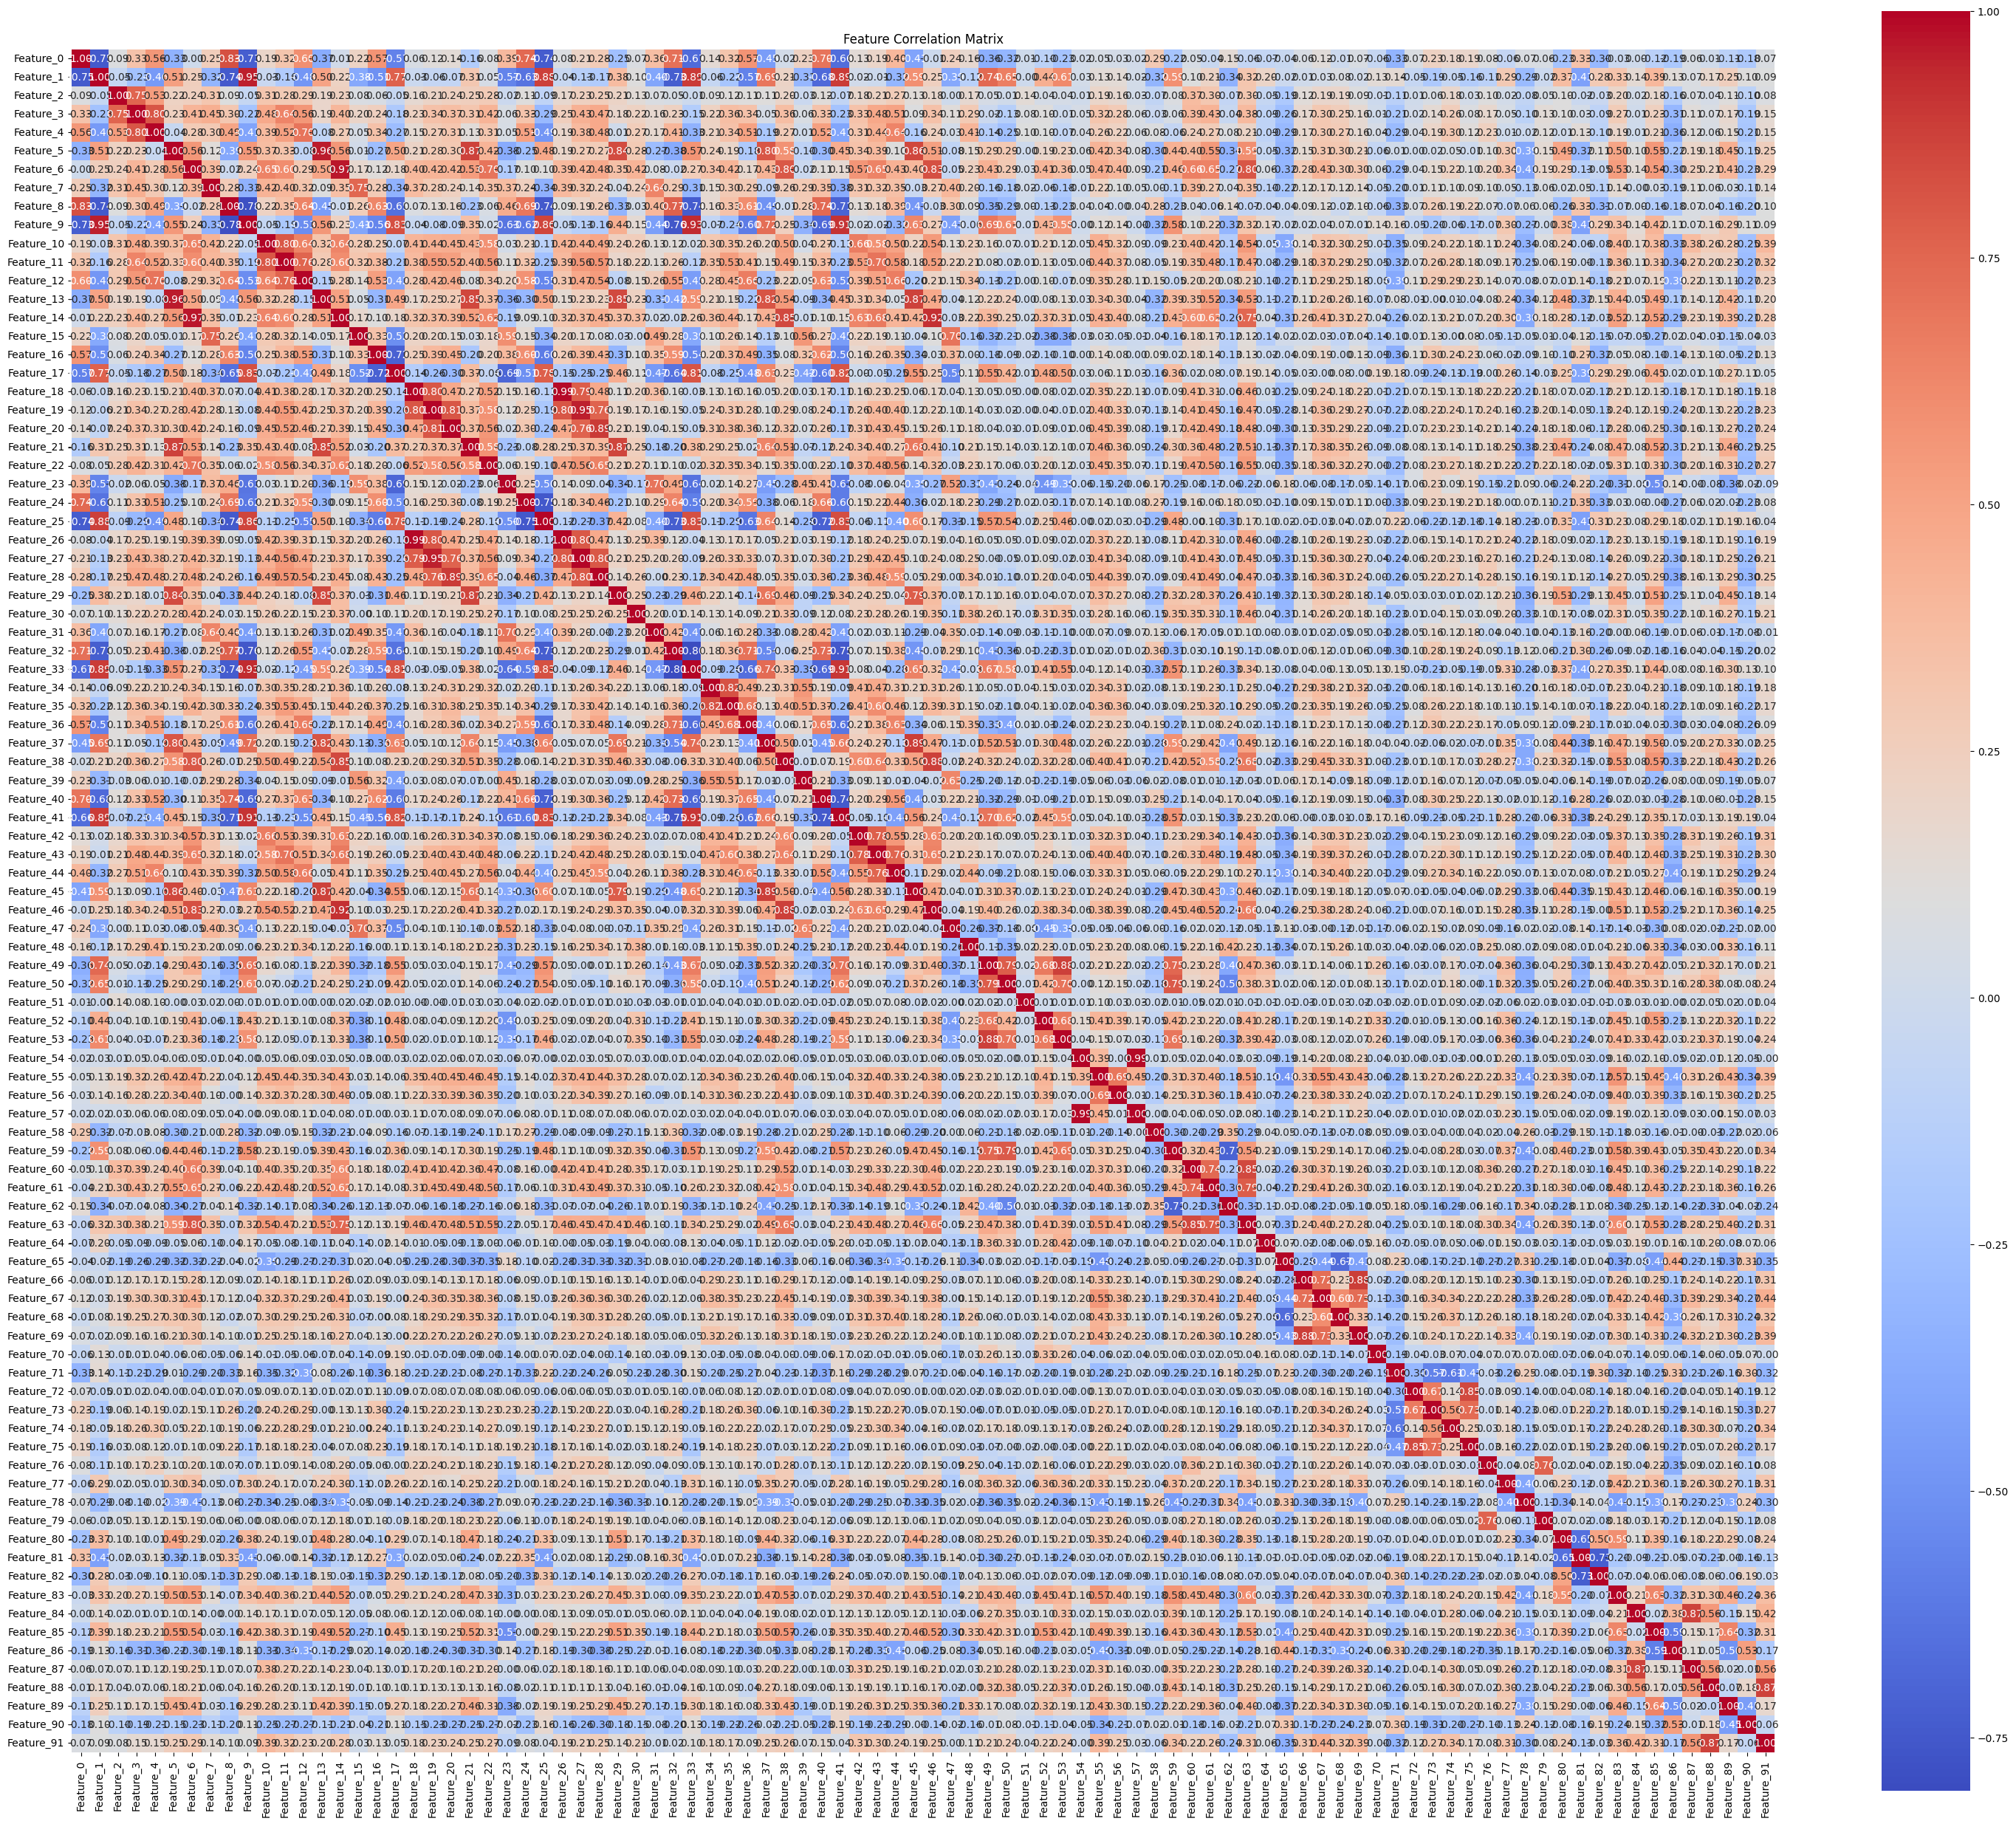

In [38]:
feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_names)

corr_matrix = df_features.corr()

plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [10]:
mask = ~np.isnan(X).any(axis=1)

X = X[mask]
y = y[mask]

full_df = pd.DataFrame(X)   
full_df['Sleep_Stage'] = y
full_df.to_csv("many_features.csv")


In [33]:
print(X.shape)

(742, 64)
